In [13]:
# =====================================================
# 1. IMPORTS AND SETUP
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import calendar
import warnings
warnings.filterwarnings('ignore')
%pip install xgboost lightgbm
%pip install imblearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import Pipeline
import joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
# =====================================================
# 2. LOAD DATA
# =====================================================
df = pd.read_csv('data/dataset.csv')
df_copy = df.copy()

# =====================================================
# 3. CLEANING & PREPROCESSING
# =====================================================
# Clean strings (removes whitespace, leading/trailing underscores)
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        df_copy[col] = df_copy[col].str.strip().str.strip('_')

# Specific column fixes
df_copy['Customer_ID'] = df_copy['Customer_ID'].str.lstrip('CUS_0x')
df_copy['Payment_Behaviour'] = df_copy['Payment_Behaviour'].replace('!@9#%8', np.nan)
df_copy['Occupation'] = df_copy['Occupation'].replace('', np.nan)
df_copy['Credit_Mix'] = df_copy['Credit_Mix'].replace('', np.nan)
df_copy['Payment_of_Min_Amount'].replace('NM', 'No', inplace=True)

# Month name to number
month_to_num = {m:i for i,m in enumerate(calendar.month_name) if m}
df_copy['Month'] = df_copy['Month'].map(month_to_num)

# Drop irrelevant privacy columns
df_copy.drop(columns=[c for c in ["ID","SSN","Name"] if c in df_copy.columns], inplace=True)

# =====================================================
# 4. TYPE CONVERSION & RANGE VALIDATION
# =====================================================
float_cols = ['Annual_Income','Interest_Rate', 'Monthly_Inhand_Salary', 'Changed_Credit_Limit',
              'Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month',
              'Amount_invested_monthly','Monthly_Balance']

int_cols = ['Age','Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan',
            'Delay_from_due_date','Num_of_Delayed_Payment','Num_Credit_Inquiries']

for col in float_cols:
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

for col in int_cols:
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

# Drop out-of-range values 
for col in ['Age','Num_Bank_Accounts','Num_Credit_Card','Num_of_Loan',
            'Num_of_Delayed_Payment','Num_Credit_Inquiries','Interest_Rate']:
    df_copy.loc[(df_copy[col]<0)|(df_copy[col]>100), col] = np.nan
df_copy.loc[(df_copy['Num_Bank_Accounts']>60)|(df_copy['Num_Bank_Accounts']<0), 'Num_Bank_Accounts'] = np.nan

In [15]:
# =====================================================
# 5. IMPUTATION (GROUPWISE)
# =====================================================
def impute_by_customer_median(df, columns):
    group_medians = df.groupby('Customer_ID')[columns].median()
    for col in columns:
        df[col] = df[col].fillna(df['Customer_ID'].map(group_medians[col]))
    return df

def impute_by_customer_mode(df, columns):
    for col in columns:
        modes = df.groupby('Customer_ID')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        df[col] = df[col].fillna(df['Customer_ID'].map(modes))
    return df

df_copy = impute_by_customer_median(df_copy, float_cols + int_cols)
cat_cols = df_copy.select_dtypes(include='object').columns.tolist()
df_copy = impute_by_customer_mode(df_copy, [c for c in cat_cols if c!='Credit_History_Age'])

# Impute global mode for 'Type_of_Loan'
if 'Type_of_Loan' in df_copy.columns:
    mode_value = df_copy['Type_of_Loan'].mode()[0]
    df_copy['Type_of_Loan'] = df_copy['Type_of_Loan'].fillna(mode_value)


In [16]:
# =====================================================
# 6. CONVERT CREDIT HISTORY AGE TO MONTHS
# =====================================================
def convert_age_to_months(age_str):
    if pd.isna(age_str) or age_str in ['NA', '_', '']:
        return np.nan
    match = re.match(r"(\d+)\s*Years\s*and\s*(\d+)\s*Months", str(age_str))
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years*12 + months
    return np.nan

if 'Credit_History_Age' in df_copy.columns:
    df_copy['Credit_History_Age_Months'] = df_copy['Credit_History_Age'].apply(convert_age_to_months)
    df_copy['Credit_History_Age_Months'] = df_copy['Credit_History_Age_Months'].fillna(df_copy['Credit_History_Age_Months'].median())
    df_copy.drop(columns=['Credit_History_Age'], inplace=True)

In [17]:
# =====================================================
# 7. ENCODING & FEATURE ENGINEERING
# =====================================================
# Label encoding for single categorical columns
le_occ = LabelEncoder()
le_pb  = LabelEncoder()
df_copy['Occupation'] = le_occ.fit_transform(df_copy['Occupation'])
df_copy['Payment_Behaviour'] = le_pb.fit_transform(df_copy['Payment_Behaviour'])

# Ordinal encoding for ordinal categories
encoded_cols = ['Credit_Mix', 'Payment_of_Min_Amount', 'Credit_Score']
oe = OrdinalEncoder()
df_copy[encoded_cols] = oe.fit_transform(df_copy[encoded_cols])

# MultiLabelBinarizer for loan types
def split_loan_types(val):
    if pd.isna(val): return []
    return [loan.strip() for loan in str(val).replace(" and ", ", ").split(",") if loan.strip()]
if 'Type_of_Loan' in df_copy.columns:
    df_copy["Type_of_Loan_List"] = df_copy["Type_of_Loan"].apply(split_loan_types)
    mlb = MultiLabelBinarizer()
    loan_dummies = pd.DataFrame(mlb.fit_transform(df_copy['Type_of_Loan_List']),
                                columns=mlb.classes_,index=df_copy.index)
    df_copy = pd.concat([df_copy, loan_dummies], axis=1)
    df_copy.drop(columns=['Type_of_Loan','Type_of_Loan_List'], inplace=True)

# Outlier capping (choose appropriate quantiles for your data)
for feature in ['Annual_Income','Age','Monthly_Inhand_Salary']:
    lower = df_copy[feature].quantile(0.06)
    upper = df_copy[feature].quantile(0.94)
    df_copy[feature+'_Capped'] = df_copy[feature].clip(lower=lower, upper=upper)
    df_copy.drop(columns=feature, inplace=True)

# Log transformation (for capped features)
for feature in ['Annual_Income_Capped','Monthly_Inhand_Salary_Capped', 'Age_Capped']:
    df_copy[feature+'_log'] = np.log1p(df_copy[feature])

# Feature engineering: ratios and flags
df_copy['DTI'] = df_copy['Total_EMI_per_month'] / df_copy['Monthly_Inhand_Salary_Capped']
df_copy['EMI_to_Income'] = df_copy['Outstanding_Debt'] / df_copy['Annual_Income_Capped']
df_copy['Invest_to_Income'] = df_copy['Amount_invested_monthly'] / df_copy['Monthly_Inhand_Salary_Capped']
df_copy['Balance_to_Income'] = df_copy['Monthly_Balance'] / df_copy['Monthly_Inhand_Salary_Capped']
df_copy['Avg_Delay_if_Delayed'] = df_copy['Delay_from_due_date'] / df_copy['Num_of_Delayed_Payment'].replace(0, 1)
df_copy['Has_Delays'] = (df_copy['Num_of_Delayed_Payment'] > 0).astype(int)
df_copy['High_Utilization'] = (df_copy['Credit_Utilization_Ratio'] > 0.7).astype(int)
df_copy['Total_Financial_Products'] = df_copy['Num_Bank_Accounts'] + df_copy['Num_Credit_Card'] + df_copy['Num_of_Loan']
df_copy['Inquiries_per_Year'] = df_copy['Num_Credit_Inquiries'] / (df_copy['Credit_History_Age_Months']/12).replace(0, 1)
df_copy['Limit_Decrease_Flag'] = (df_copy['Changed_Credit_Limit'] < 0).astype(int)
df_copy['Large_Limit_Change'] = (df_copy['Changed_Credit_Limit'].abs() > 20).astype(int)
loan_cols = [col for col in df_copy.columns if col.endswith("Loan")]
df_copy['Num_Loan_Types'] = df_copy[loan_cols].sum(axis=1)

# Drop columns that have been fully replaced with engineered features
drop_cols = ['Total_EMI_per_month','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance',
             'Delay_from_due_date','Num_of_Delayed_Payment','Credit_Utilization_Ratio','Num_Bank_Accounts',
             'Num_Credit_Card','Num_of_Loan','Num_Credit_Inquiries','Credit_History_Age_Months',
             'Changed_Credit_Limit','Credit_Mix','Monthly_Inhand_Salary_Capped','Annual_Income_Capped','Age_Capped']
df_copy.drop(columns=[col for col in drop_cols if col in df_copy.columns], inplace=True)

# Drop Customer_ID if present
if 'Customer_ID' in df_copy.columns:
    df_copy.drop(columns=['Customer_ID'], inplace=True)

df_copy.to_csv('data/cleaned_dataset.csv', index=False)
print("Final feature list:", df_copy.columns.tolist())


Final feature list: ['Month', 'Occupation', 'Interest_Rate', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score', 'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan', 'Annual_Income_Capped_log', 'Monthly_Inhand_Salary_Capped_log', 'Age_Capped_log', 'DTI', 'EMI_to_Income', 'Invest_to_Income', 'Balance_to_Income', 'Avg_Delay_if_Delayed', 'Has_Delays', 'High_Utilization', 'Total_Financial_Products', 'Inquiries_per_Year', 'Limit_Decrease_Flag', 'Large_Limit_Change', 'Num_Loan_Types']


In [ ]:
# =====================================================
# 8. MODEL TRAIN/TEST SPLIT & PREPARATION
# =====================================================
X = df_copy.drop(columns=['Credit_Score'])
y = df_copy['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Remove highly correlated features (>0.9)
corr_matrix = X_train.corr().abs()
redundant = set()
threshold = 0.9
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            redundant.add(corr_matrix.columns[j])

X_train_reduced = X_train.drop(columns=list(redundant))
X_test_reduced  = X_test.drop(columns=list(redundant))


In [19]:
    # ======================================================
    # 9. ADVANCED MODELING: XGBoost, SMOTE, Ensembling
    # ======================================================
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
# Note: other sklearn imports (GridSearchCV, cross_val_score, RandomForestClassifier, metrics) are already imported in cell 0

# Impute missing values before algorithms that do not accept NaNs (fit imputer on training only)
imputer = SimpleImputer(strategy='median')
X_train_reduced_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_reduced),
    columns=X_train_reduced.columns,
    index=X_train_reduced.index
    )
X_test_reduced_imputed = pd.DataFrame(
        imputer.transform(X_test_reduced),
        columns=X_test_reduced.columns,
        index=X_test_reduced.index
    )

    # ----------- Stacking Classifier (Ensemble) -----------
estimators = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
        ('lgbm', LGBMClassifier(n_estimators=100, random_state=42))
    ]
stacking_clf = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1)
    # fit stacking on imputed data to avoid NaN issues
stacking_clf.fit(X_train_reduced_imputed, y_train)
y_pred_stack = stacking_clf.predict(X_test_reduced_imputed)
print("Stacked model accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

    # ----------- Hyperparameter Tuning Example (XGBoost) -----------
param_grid_xgb = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.05, 0.1, 0.2]
    }
grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_reduced_imputed, y_train)
print("Best XGBoost parameters:", grid_xgb.best_params_)
print("Best XGBoost CV score:", grid_xgb.best_score_)


Stacked model accuracy: 0.8179
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      3566
         1.0       0.81      0.83      0.82      5799
         2.0       0.83      0.83      0.83     10635

    accuracy                           0.82     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.82      0.82      0.82     20000

Best XGBoost parameters: {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200}
Best XGBoost CV score: 0.7914624825908644


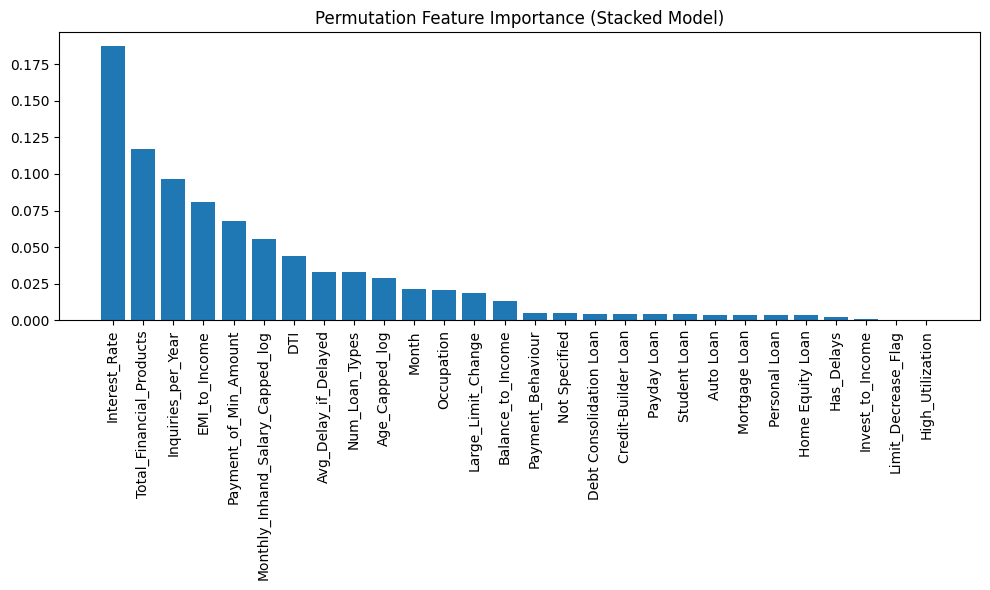

Top 10 Permuted Important Features:
Interest_Rate: 0.1874
High_Utilization: 0.1172
Total_Financial_Products: 0.0967
DTI: 0.0811
Payment_of_Min_Amount: 0.0679
Annual_Income_Capped_log: 0.0556
Age_Capped_log: 0.0440
Balance_to_Income: 0.0332
Large_Limit_Change: 0.0331
Monthly_Inhand_Salary_Capped_log: 0.0288


In [20]:
# =====================================================
# 10. FEATURE/ERROR INTERPRETATION AND VISUALIZATION
# =====================================================
# Permutation importance
result = permutation_importance(stacking_clf, X_test_reduced_imputed, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.bar(range(len(result.importances_mean)), result.importances_mean[sorted_idx], align="center")
plt.xticks(range(len(result.importances_mean)), X_test_reduced_imputed.columns[sorted_idx], rotation=90)
plt.title("Permutation Feature Importance (Stacked Model)")
plt.tight_layout()
plt.show()

print("Top 10 Permuted Important Features:")
for i in range(10):
    feat = X_test.columns[sorted_idx[i]]
    val = result.importances_mean[sorted_idx[i]]
    print(f"{feat}: {val:.4f}")


In [21]:
# =====================================================
# 11. PIPELINE PREPARATION FOR DEPLOYMENT
# =====================================================
# pipeline = Pipeline([('model', rf_best)])
full_pipeline = Pipeline([
    ('imputer', imputer),
    ('model', stacking_clf)
])
full_pipeline.fit(X_train_reduced, y_train)
joblib.dump(full_pipeline, "credit_best_pipeline.pkl")
joblib.dump(X_train_reduced.columns.tolist(), "credit_feature_columns.pkl")
print("Best pipeline and feature columns saved.")

# --- 6. Prediction Function ---
def predict_new(data_row):
    model_pipe = joblib.load("credit_best_pipeline.pkl")
    feature_list = joblib.load("credit_feature_columns.pkl")
    X_new = pd.DataFrame([data_row])[feature_list]
    pred = model_pipe.predict(X_new)[0]
    class_map = {0: 'Poor', 1: 'Standard', 2: 'Good'}
    return class_map.get(int(pred), pred)

# =====================================================
# YOU CAN EXTEND: Use Streamlit, FastAPI, or Flask as frontend for API integration.
# =====================================================

print("Credit scoring project: End-to-End code complete.")


Best pipeline and feature columns saved.
Credit scoring project: End-to-End code complete.
